# Task 2 - Anomaly Detection

> Luca Laboccetta,  
> Giorgio Andronico 


## Data understanding

### Initial data collection

Boilerplate code: importing useful models, choosing compute backend, mounting Google Drive, etc.

In [ ]:
# Install keras tuner
!pip install -q -U keras-tuner

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Masking, Dense
from keras.models import Sequential
from google.colab import drive
import keras_tuner as kt
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Choose computing backend
computing_resource = tf.test.gpu_device_name()
if "GPU" not in computing_resource:
    computing_resource = "/CPU:0"
print(f"Computing resource: {computing_resource}")

# Mount Google Drive
drive.mount('/content/drive')

# Setting seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 43.5 MB/s 
Computing resource: /device:GPU:0
Mounted at /content/drive


### Data exploration

Reading the *Healthware* datasets, both train and test

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/task2/ad_train.csv")
test = pd.read_csv("/content/drive/MyDrive/DeepLearning/Datasets/Progetto/task2/ad_test.csv")
test_by_patient = [d for _, d in test.groupby(['patient'])] # needed later on for AD phase

Get info on the datasets' shape

In [ ]:
print(train.shape)
print(test.shape)

(943522, 7)
(722787, 7)


Get the first ten rows of both train and test sets

In [ ]:
train.head()

,patient,x,y,z,heartRate,timestamp,tsDate
0,1502,23,569,878,-1,1568073600000,2019-09-10 00:00:00.003
1,1502,23,571,878,-1,1568073601000,2019-09-10 00:00:01.014
2,1502,23,570,878,-1,1568073602000,2019-09-10 00:00:02.025
3,1502,23,570,878,-1,1568073603000,2019-09-10 00:00:03.035
4,1502,23,570,878,-1,1568073604000,2019-09-10 00:00:04.046


In [ ]:
test.head()

,patient,timestamp,tsDate,x,y,z,heartRate
0,1004,1567224000000,2019-08-31 04:00:00.004,-24,749,-626,77
1,1004,1567224010000,2019-08-31 04:00:10.022,-206,930,-63,77
2,1004,1567224020000,2019-08-31 04:00:20.041,-139,763,-577,72
3,1004,1567224030000,2019-08-31 04:00:30.059,-503,441,-557,73
4,1004,1567224040000,2019-08-31 04:00:40.060,-278,705,-396,78


Get relevant statistical quantities of both train and test sets, for relevant columns

In [ ]:
train[['x', 'y', 'z', 'heartRate']].describe(include='all')

,x,y,z,heartRate
count,943522.000000,943522.000000,943522.000000,943522.000000
mean,-82.993777,265.351292,-203.930526,70.203571
std,577.033231,539.747675,534.955382,20.973755
min,-1649.000000,-1082.000000,-1256.000000,-1.000000
25%,-532.000000,-59.000000,-665.000000,61.000000
50%,-91.000000,313.000000,-223.000000,70.000000
75%,311.000000,739.000000,125.000000,82.000000
max,1796.000000,1644.000000,1127.000000,182.000000


In [ ]:
test[['x', 'y', 'z', 'heartRate']].describe(include='all')

,x,y,z,heartRate
count,722787.000000,722787.000000,722787.000000,722787.000000
mean,68.439576,198.843647,-314.757154,78.074942
std,544.046974,542.450042,513.241910,12.534722
min,-1239.000000,-1019.000000,-1048.000000,29.000000
25%,-319.000000,-158.000000,-759.000000,70.000000
50%,75.000000,275.000000,-400.000000,77.000000
75%,507.000000,659.000000,58.000000,87.000000
max,1184.000000,1078.000000,1044.000000,168.000000


Checking for null values

In [ ]:
train.isnull().sum()

patient      0
x            0
y            0
z            0
heartRate    0
timestamp    0
tsDate       0
dtype: int64

In [ ]:
test.isnull().sum()

patient      0
timestamp    0
tsDate       0
x            0
y            0
z            0
heartRate    0
dtype: int64

The data description specified that, in the rows where the heartrate is not available, a placeholder value of -1 is used. Let's check how many rows satisfy this condition, so to treat them later.

In [ ]:
train[train.heartRate == -1].count()

patient      39029
x            39029
y            39029
z            39029
heartRate    39029
timestamp    39029
tsDate       39029
dtype: int64

In [ ]:
test[test.heartRate == -1].count()

patient      0
timestamp    0
tsDate       0
x            0
y            0
z            0
heartRate    0
dtype: int64

Checking how many patients we have in the training and testing set

In [ ]:
train_patients = train.patient.unique()
train_patients

array([1502, 1503, 1505, 1507, 1509, 3506, 3507, 3508, 3509, 4502, 4504,
       4505, 4506])

In [ ]:
test_patients = test.patient.unique()
test_patients

array([1004, 1006, 3001, 3006, 4002])

#### Data visualization

Below there are plots for all statistically relevant columns. The y-axis depicts the value of the single instance, while the x-axis is merely the row index of that instance.

Plot for column x, train set

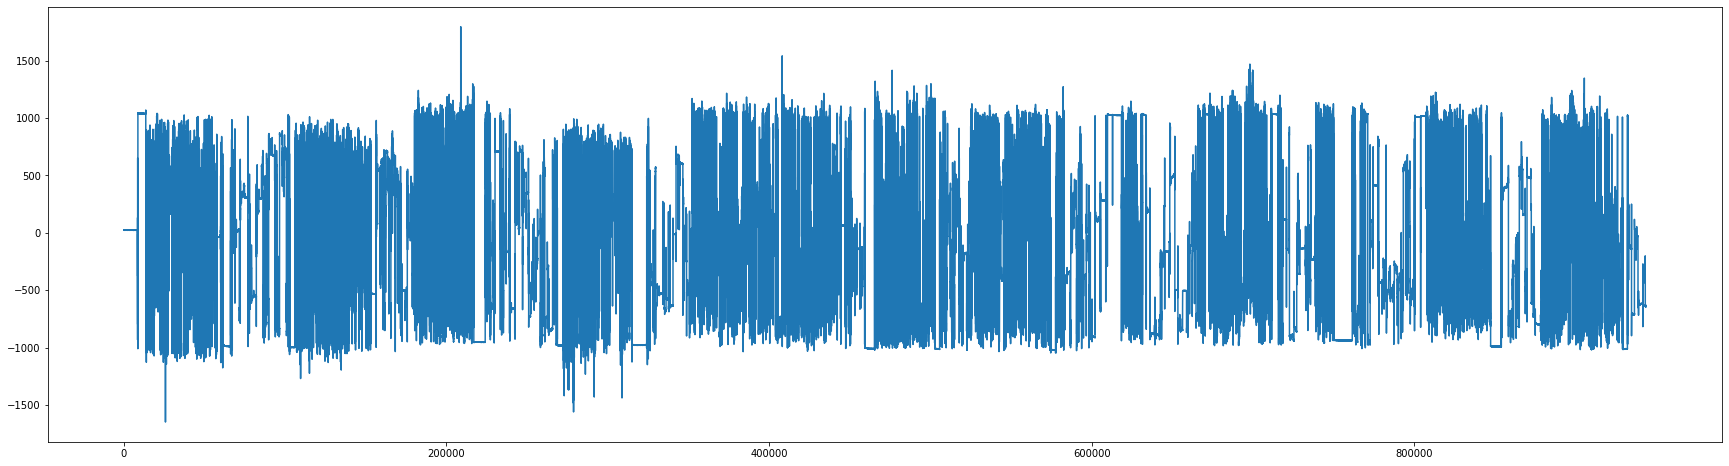

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(train.x.values)

Plot for column y, train set

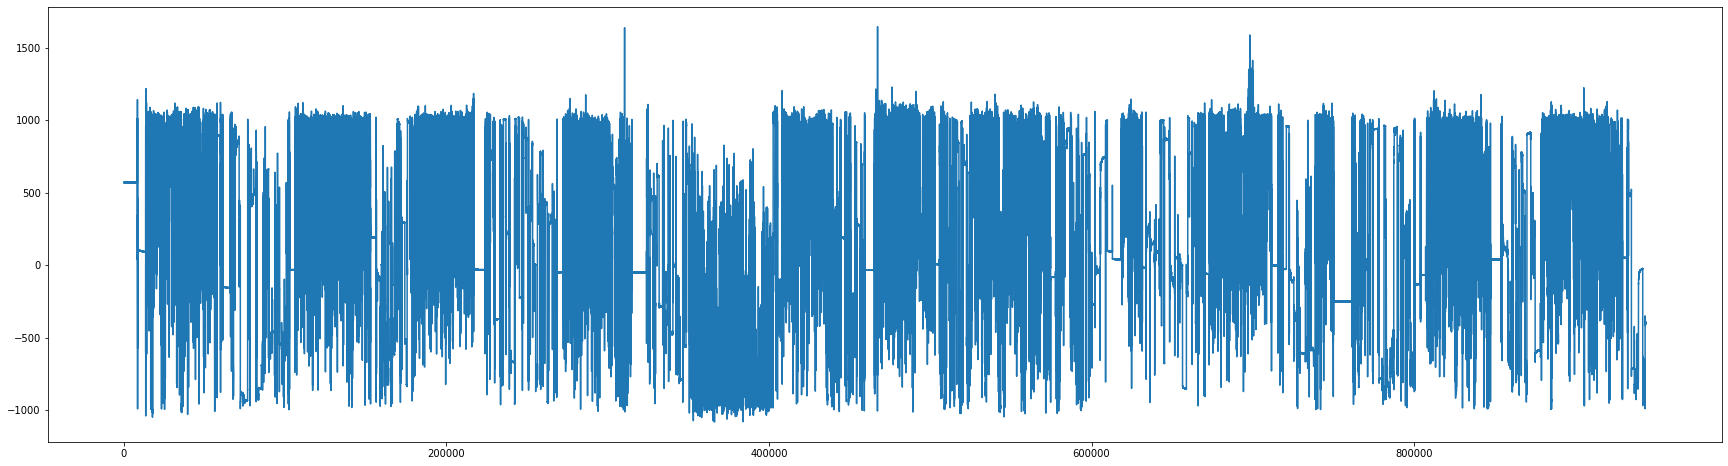

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(train.y.values)

Plot for column z, train set

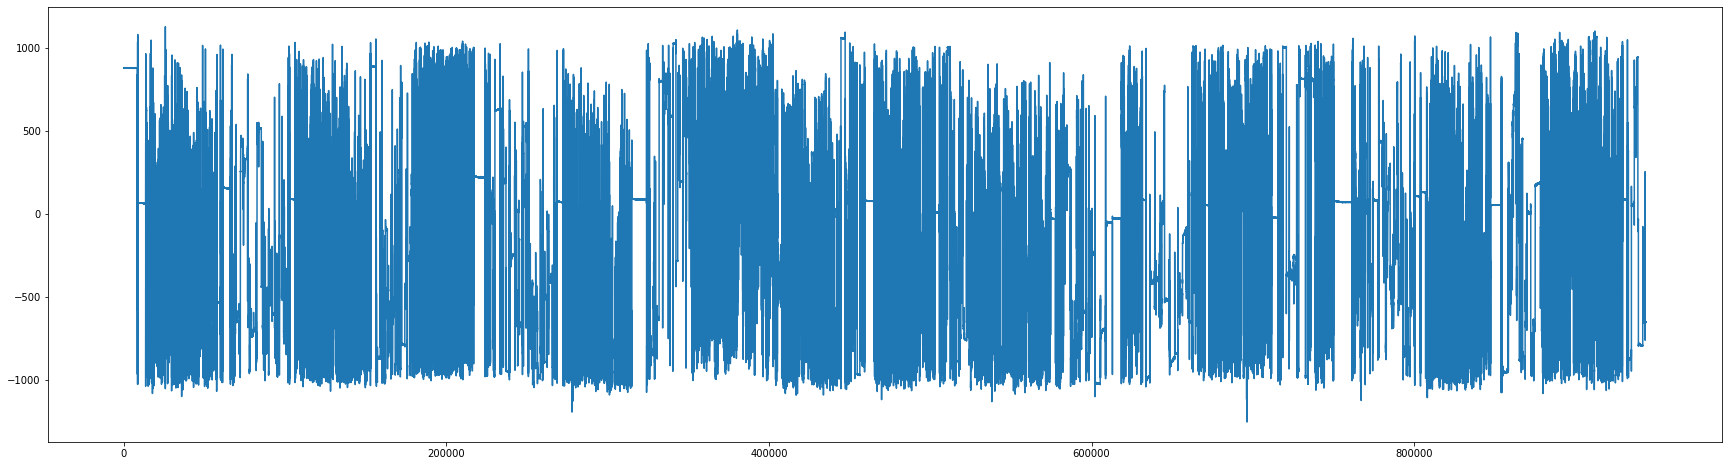

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(train.z.values)

Plot for column x, test set

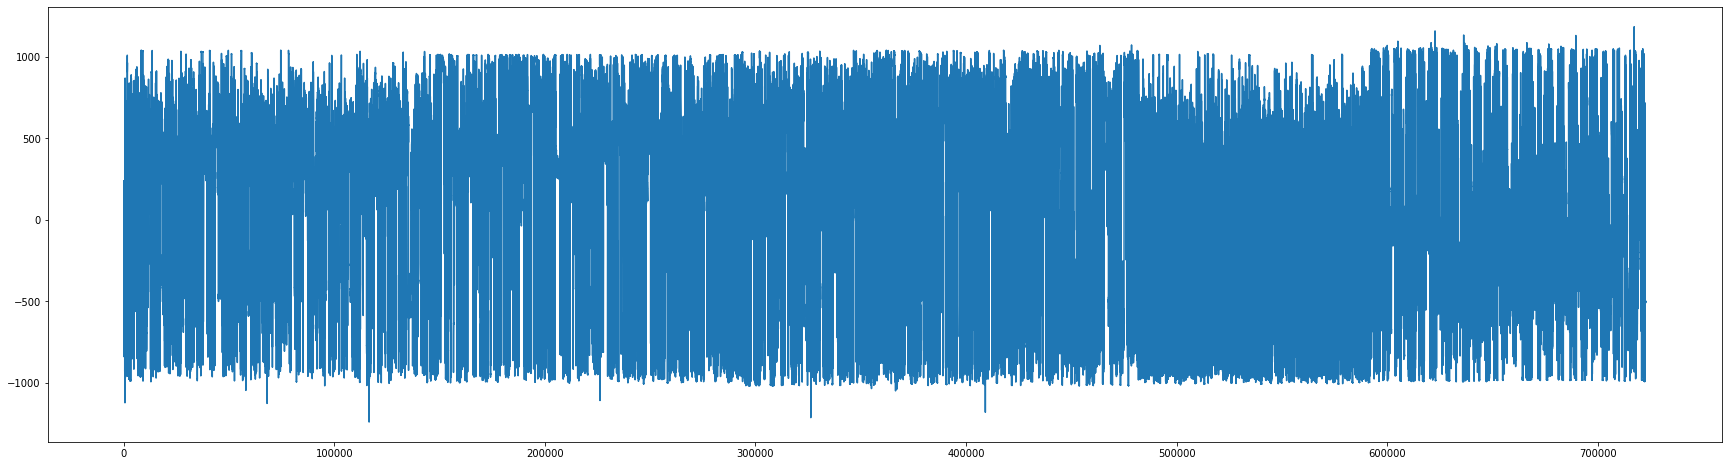

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(test.x.values)

Plot for column y, test set

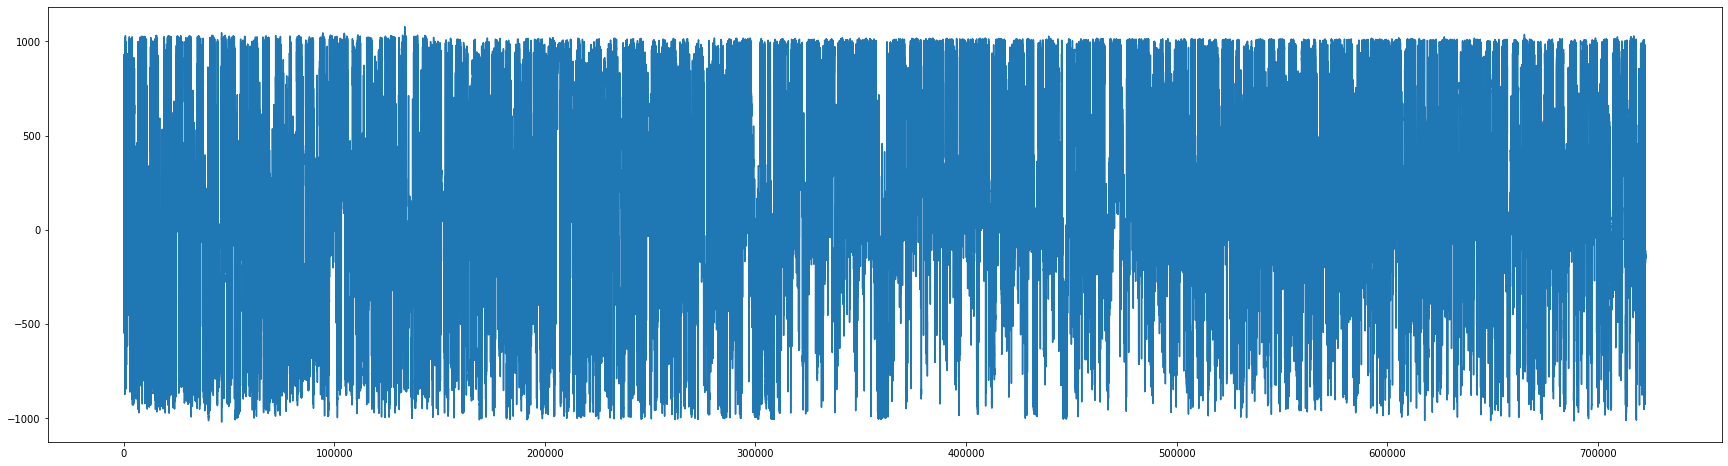

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(test.y.values)

Plot for column z, test set

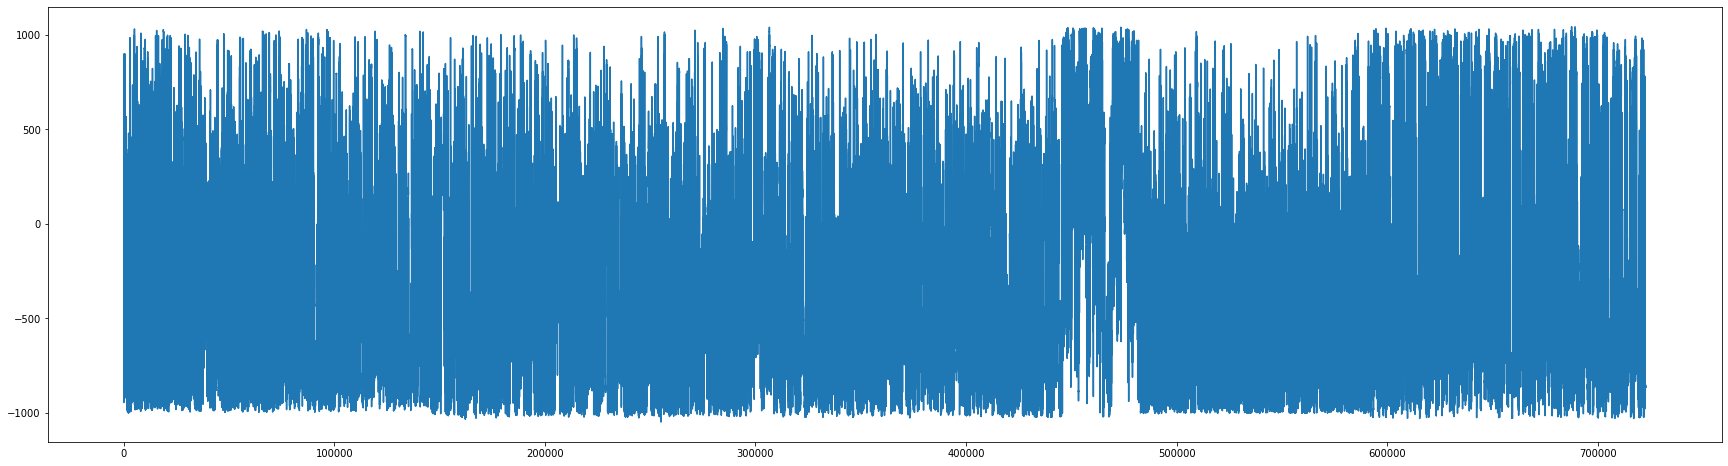

In [ ]:
fig = plt.figure(figsize=(30, 8))
plt.plot(test.z.values)

Heartrate plot for each patient, train set

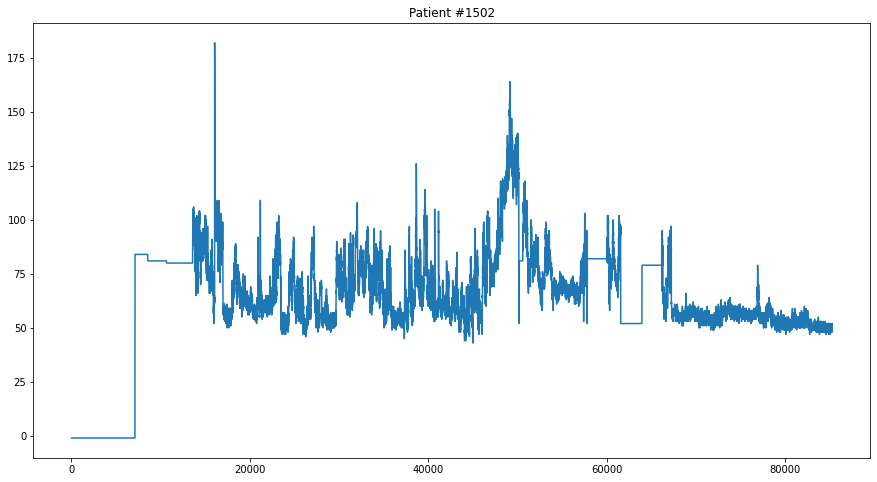

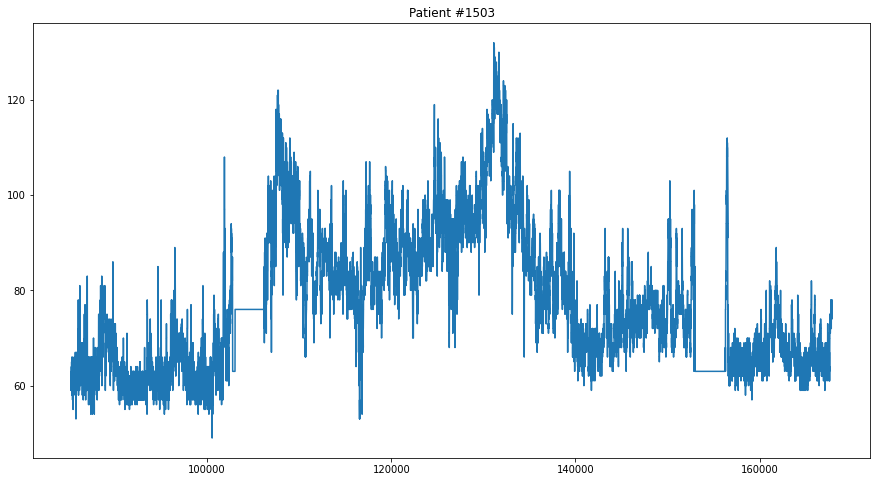

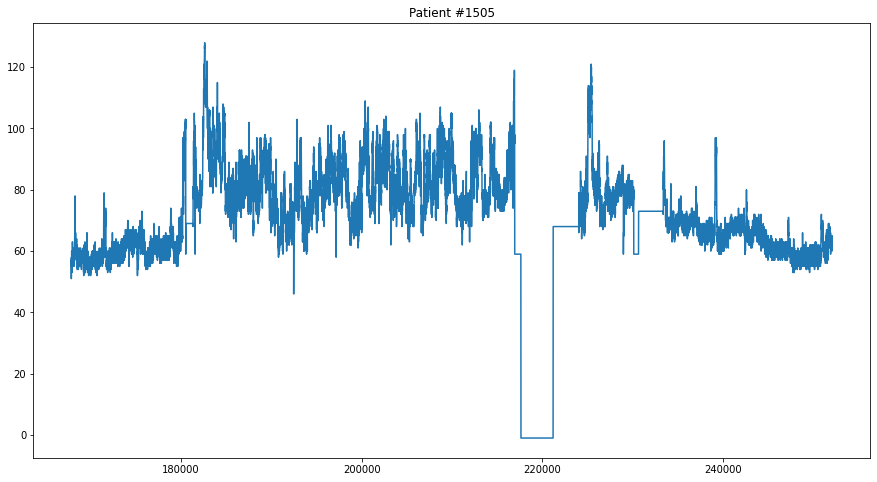

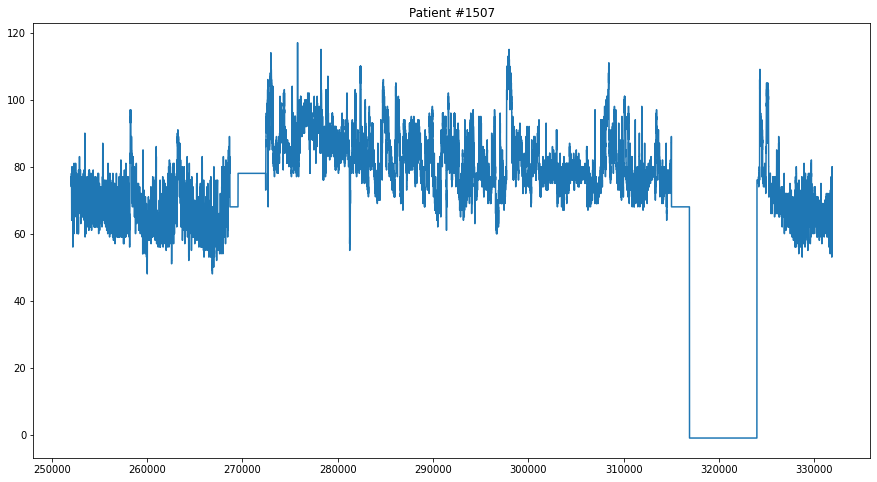

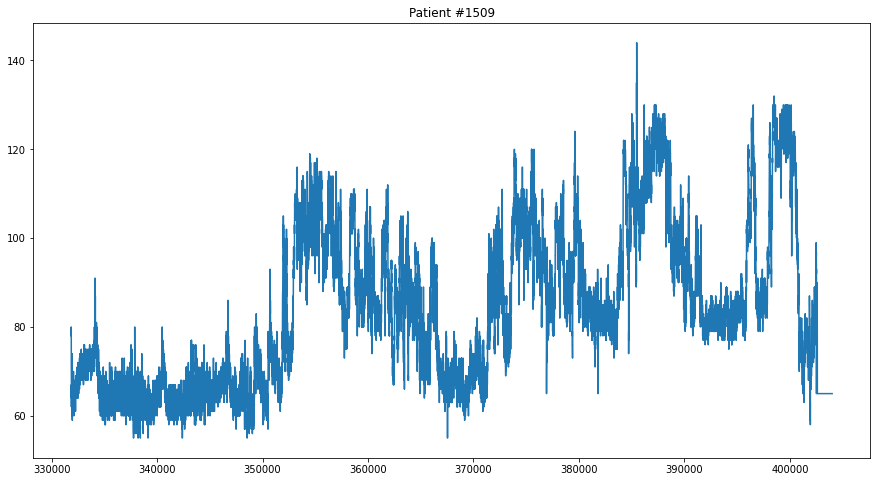

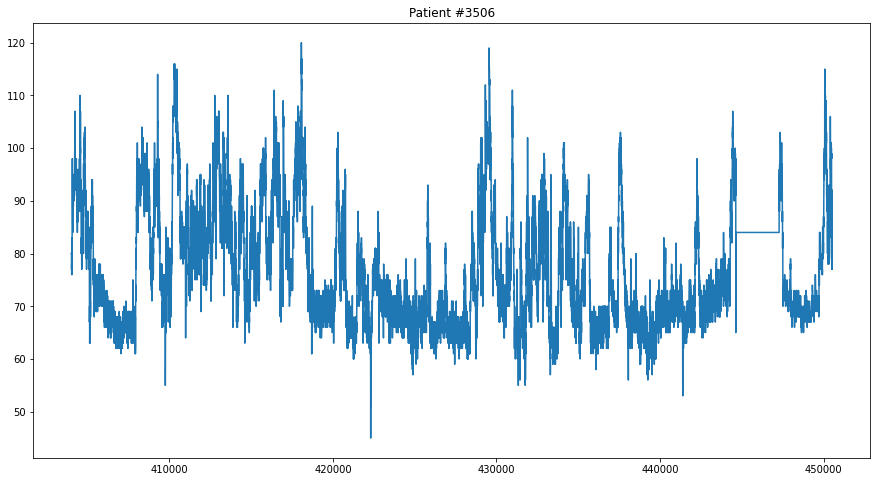

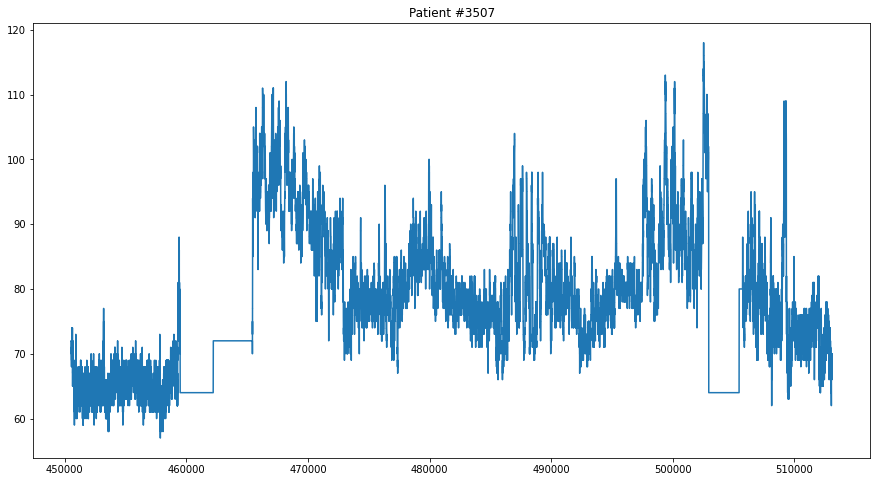

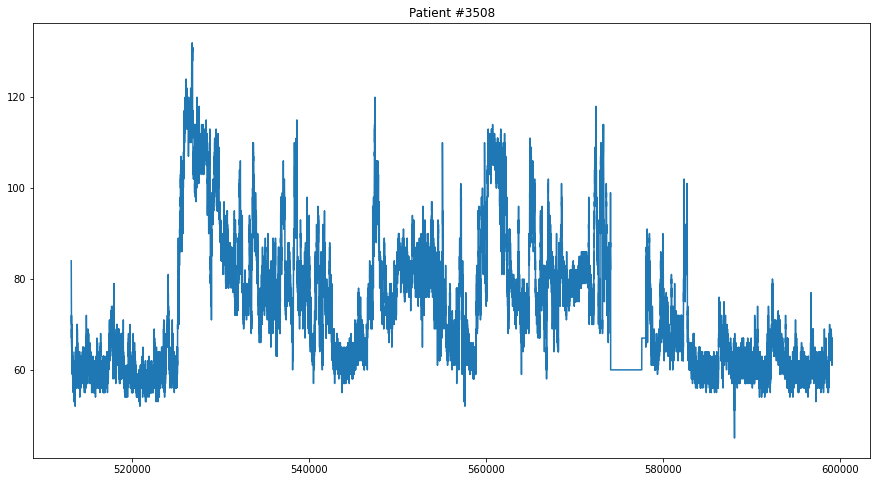

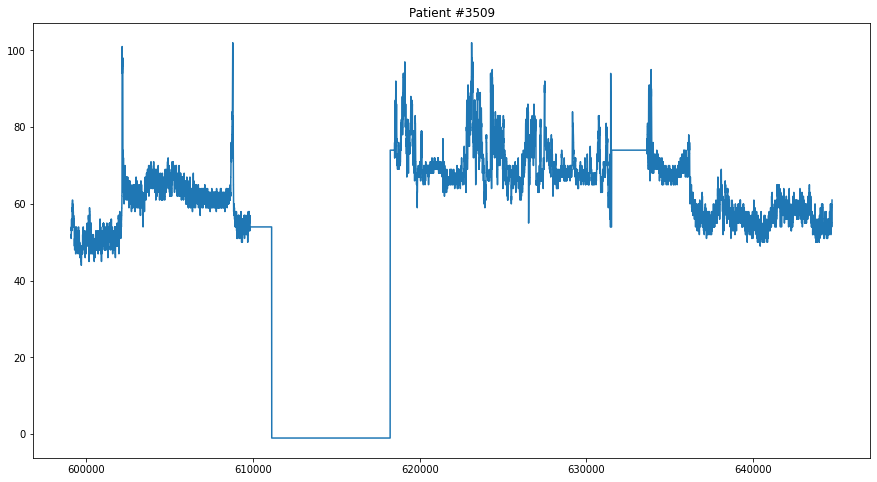

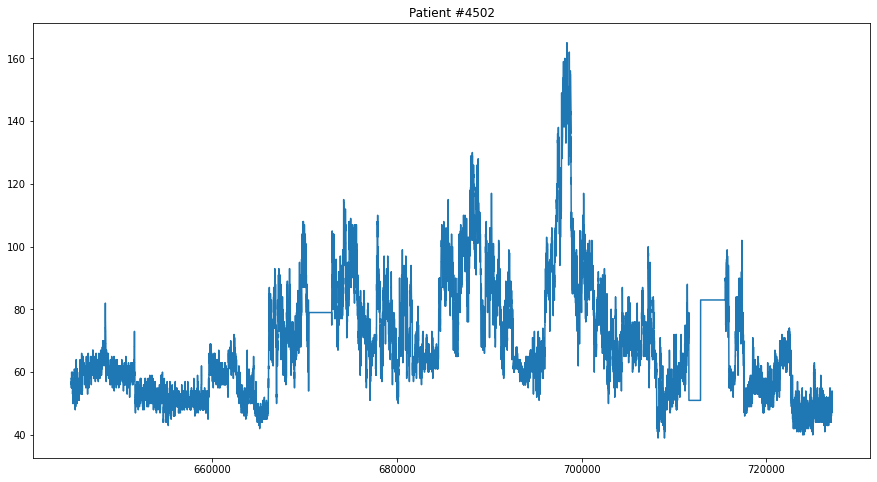

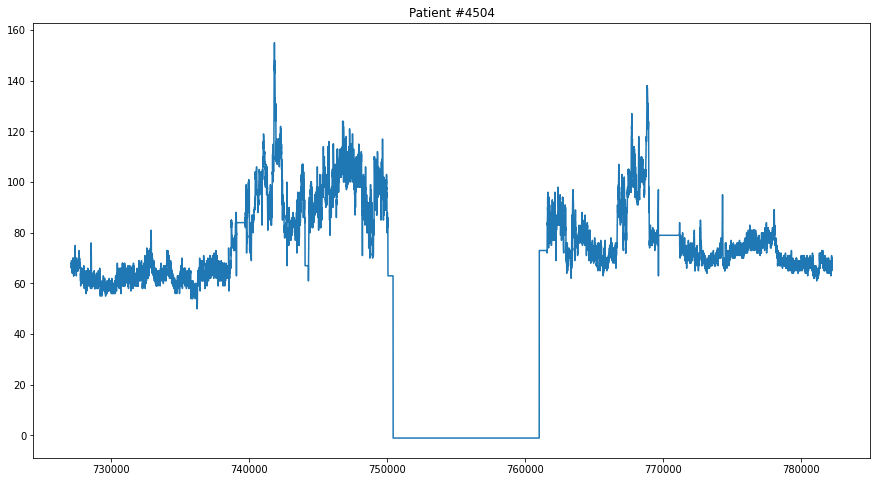

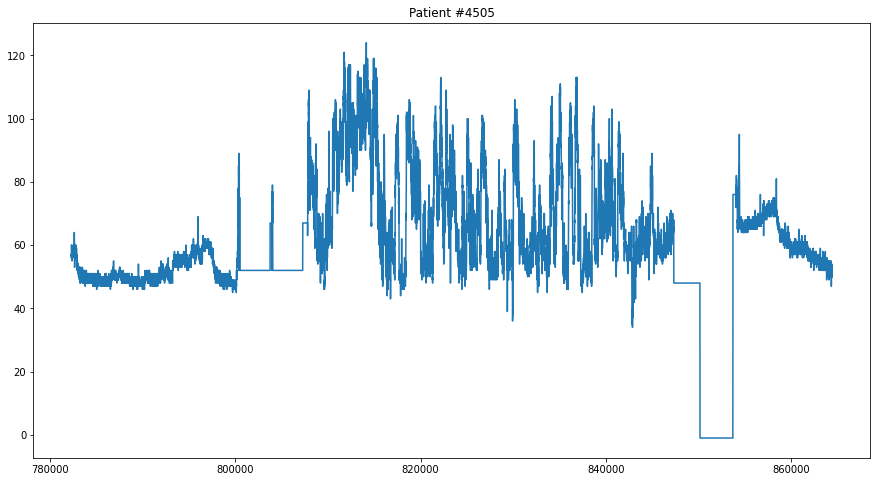

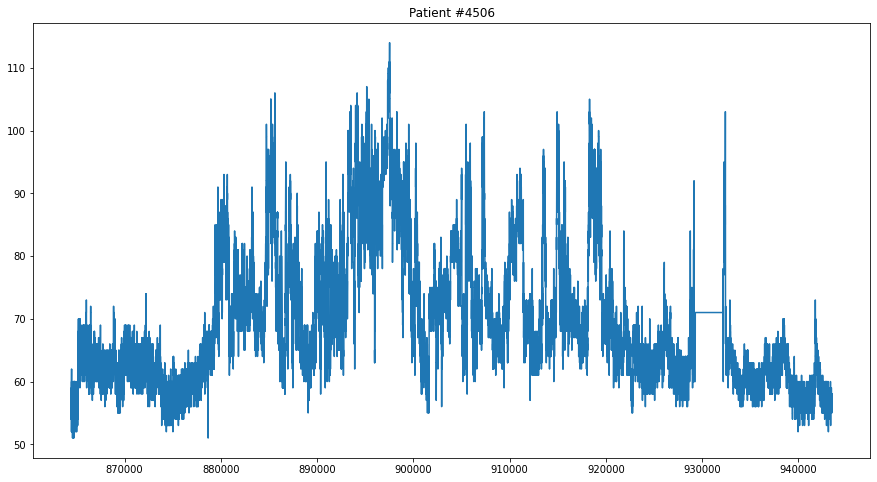

In [ ]:
patients_id = train['patient'].values
patients_id = np.unique(patients_id)

for id in patients_id:
    heartrate = train['heartRate'].where(train['patient'] == id)
    fig = plt.figure(figsize=(15, 8))
    plt.plot(heartrate)
    plt.title(f'Patient #{id}')

Heartrate plot for each patient, test set

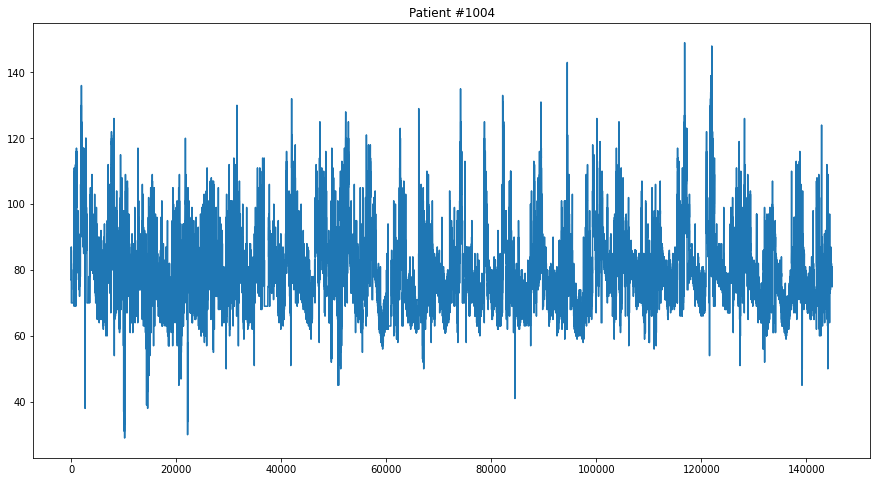

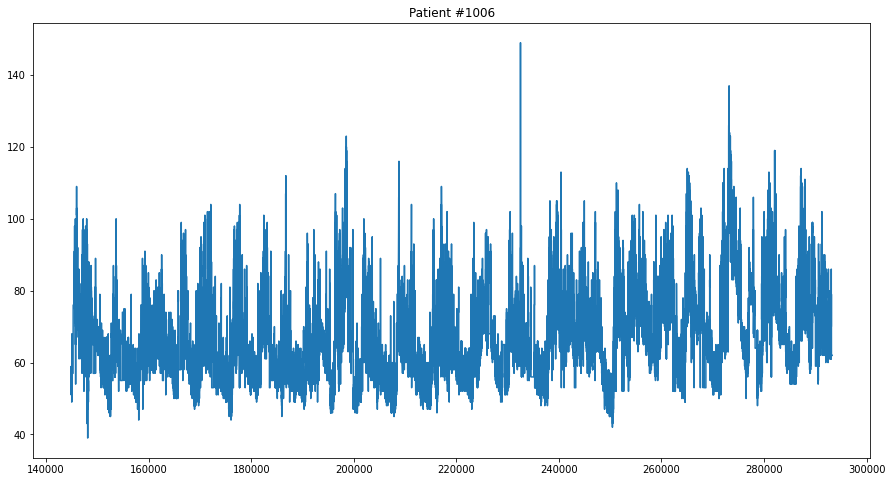

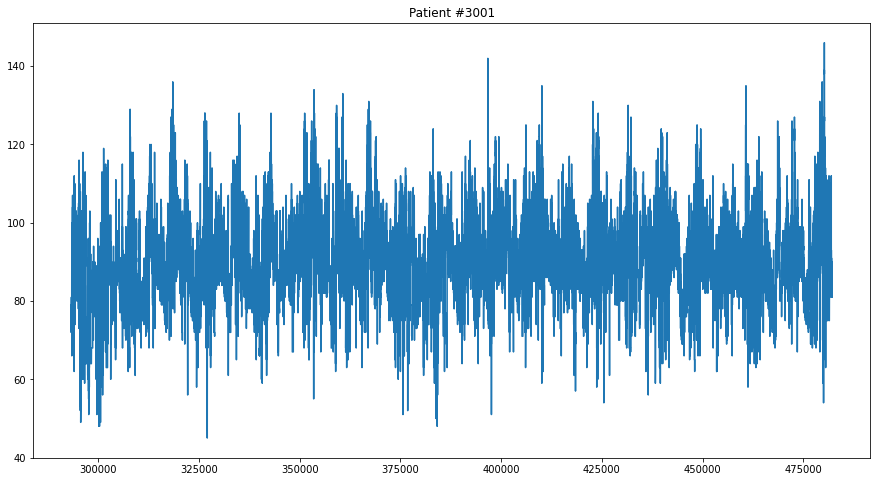

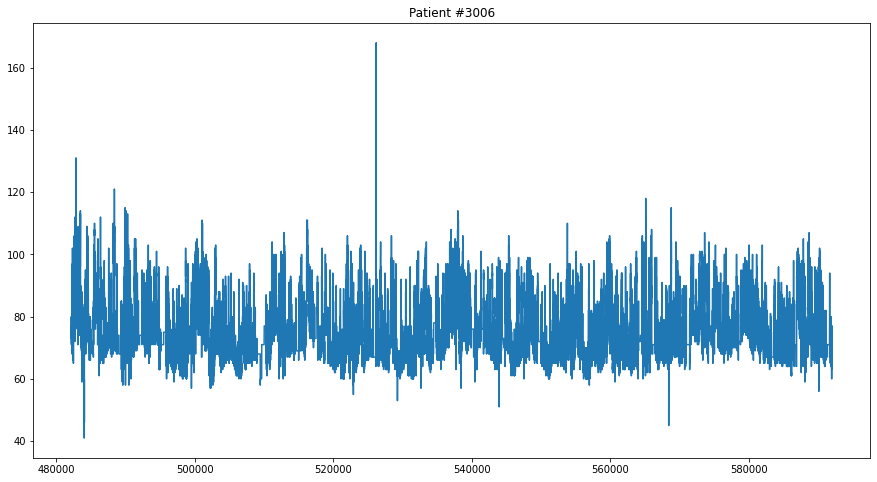

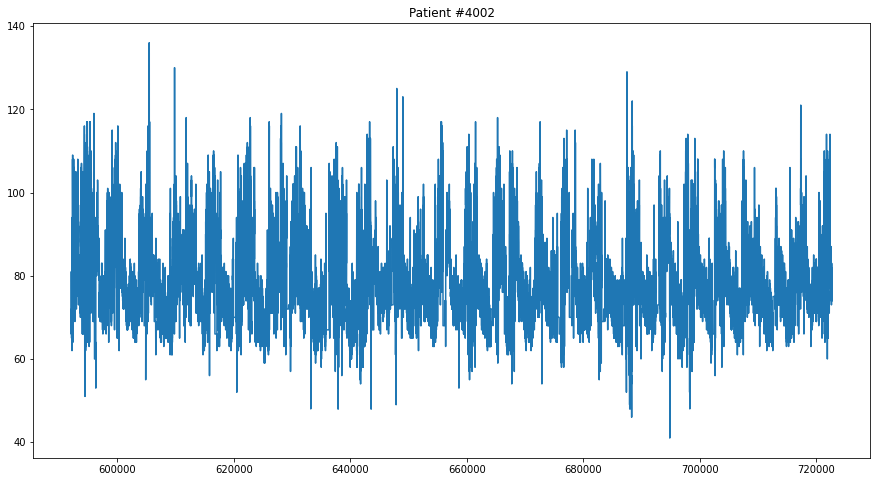

In [ ]:
patients_id = test['patient'].values
patients_id = np.unique(patients_id)

for id in patients_id:
    heartrate = test['heartRate'].where(test['patient'] == id)
    fig = plt.figure(figsize=(15, 8))
    plt.plot(heartrate)
    plt.title(f'Patient #{id}')

## Data preparation

### Problems

#### Null value cleaning

Cleaning the data from values where heartrate is not registered

In [ ]:
train = train[train.heartRate != -1]
test = test[test.heartRate != -1]

Dropping useless column. *tsDate* does the same job as *timestamp* essentially, so it can be seen as a duplicate, at least for our purposes.


In [ ]:
train.drop('timestamp', inplace=True, axis=1)
# no time columns needed for test, no need to resample
test.drop(['timestamp', 'tsDate'], inplace=True, axis=1) 

### Transformations

#### Resampling 

Changing sampling frequency from 1s to 10s on training data




In [ ]:
train.tsDate = train.tsDate.astype('datetime64[s]')

train = train.groupby(['patient', pd.Grouper(freq='10s', key='tsDate')]).mean()
train.reset_index(level=0, inplace=True)
train.reset_index(level=0, inplace=True)

train = train.reindex(columns = ['patient','tsDate','x','y','z','heartRate'])

Removing *tsDate* column which is now useless after resampling

In [ ]:
train.drop('tsDate', inplace=True, axis=1)

#### Normalization

Definition of normalizing function

In [ ]:
def normalize_df(df):
  normalized_df = df.copy()
  for feature_name in ['x', 'y', 'z', 'heartRate']:
    col_mean = normalized_df[feature_name].mean(axis = 0)
    col_std = normalized_df[feature_name].std(axis = 0)
    normalized_df[feature_name] = (normalized_df[feature_name] - col_mean) / col_std
  return normalized_df

Normalizing data, both train and test

In [ ]:
normalized_train = normalize_df(train)
normalized_test = normalize_df(test)

In [ ]:
normalized_train

,patient,x,y,z,heartRate
0,1502,0.168191,0.554780,2.137488,0.705230
1,1502,0.168560,0.555345,2.137293,0.705230
2,1502,0.168191,0.554780,2.137682,0.705230
3,1502,0.168007,0.554968,2.136515,0.705230
4,1502,0.168191,0.554592,2.137488,0.705230
...,...,...,...,...,...
91799,4506,-1.046960,-1.264399,-0.845176,-1.101085
91800,4506,-1.058415,-1.259613,-0.840052,-1.158359
91801,4506,-1.055464,-1.259425,-0.841803,-1.145142
91802,4506,-1.052698,-1.260742,-0.842971,-1.085666


In [ ]:
normalized_test

,patient,x,y,z,heartRate
0,1004,-0.169911,1.014206,-0.606425,-0.085757
1,1004,-0.504441,1.347878,0.490523,-0.085757
2,1004,-0.381290,1.040015,-0.510954,-0.484649
3,1004,-1.050350,0.446412,-0.471986,-0.404871
4,1004,-0.636782,0.933093,-0.158293,-0.005979
...,...,...,...,...,...
722782,4002,-1.046674,-0.613593,-1.068196,-0.165536
722783,4002,-1.044835,-0.611750,-1.068196,-0.005979
722784,4002,-1.044835,-0.611750,-1.068196,0.073800
722785,4002,-1.044835,-0.613593,-1.068196,-0.005979


#### Windowing and splitting

Defining the windowing function

In [ ]:
def generate_windows(df, window_size, window_shift):

  windows = []
  last_window = False

  for i in np.arange(0, df.shape[0], window_shift):
    
    end_ix = i + window_size
    if last_window:
      break

    if end_ix > df.shape[0]:
      last_window = True
      remainder = end_ix - df.shape[0]
      window = df.iloc[i:df.shape[0]]
      for j in range(0, remainder):
        window.loc[-1] = [0, 0, 0, 0, 0] 
        window.index = window.index + 1
        window = window.sort_index()
    else:
      window = df.iloc[i:end_ix]

    windows.append(window)
    
  return (remainder, np.stack(windows).astype('float32'))

Considering we have 13 patients in our training set, we select an 80%-20% split and approximating, 10.4 (approx. 10) patients end up in the training set and 2.6 (approx. 3) end up in the validation set.

In [ ]:
train_windows = []
val_windows = []

window_size = 30
window_shift = 6

for i in range(0, len(train_patients)):
  if i < 10:
    train_windows.append(generate_windows(
        normalized_train[normalized_train.patient == train_patients[i]], 
        window_size, 
        window_shift)[1])
  else:
    val_windows.append(generate_windows(
        normalized_train[normalized_train.patient == train_patients[i]], 
        window_size, 
        window_shift)[1])
    
windowed_train = np.concatenate(train_windows, axis=0)
windowed_val = np.concatenate(val_windows, axis=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Windowing the test set by patient, and keeping track of indexing info for MAE calculation later on

In [ ]:
test_windows = []

start_indices_by_patient = []
#end_indices_by_patient = []
window_count_by_patient = []
remainders_by_patient = []

for i in range(0, len(test_patients)):
    sliced_test = normalized_test[normalized_test.patient == test_patients[i]]

    generated_windows = generate_windows(
        sliced_test, 
        window_size, 
        window_shift)
    test_windows.append(generated_windows[1])
    
    first_row_index = sliced_test.index[0]
    last_row_index = sliced_test.index[-1]

    window_count_by_patient.append(len(test_windows[i]))
    start_indices_by_patient.append(first_row_index)
    #end_indices_by_patient.append(last_row_index)
    remainders_by_patient.append(generated_windows[0])

windowed_test = np.concatenate(test_windows, axis=0)

Removing patient column, not needed anymore




In [ ]:
windowed_train = np.delete(windowed_train, 0, axis=2)
windowed_val = np.delete(windowed_val, 0, axis=2)
windowed_test = np.delete(windowed_test, 0, axis=2)

Checking the shape of the training set after windowing

In [ ]:
windowed_train.shape

(11848, 30, 4)

Checking the shape of the validation set after windowing

In [ ]:
windowed_val.shape

(3411, 30, 4)

Checking the shape of the test set after windowing

In [ ]:
windowed_test.shape

(120447, 30, 4)

## Modeling

### Hyperparameter search

Defining model skeleton and search ranges for each hyperparameter

In [ ]:
def build_model(hp):
  model = Sequential()
  LSTM_1_4_units = hp.Int('LSTM_1_4_units', min_value=64, max_value=128, step=32)
  LSTM_2_3_units = hp.Int('LSTM_2_3_units', min_value=32, max_value=64, step=32)
  dropout_rate = 0.2

  model.add(Masking(mask_value=0.0, 
                    input_shape=(windowed_train.shape[1], 
                                 windowed_train.shape[2])))
  model.add(LSTM(LSTM_1_4_units,
                 activation='tanh', 
                 return_sequences=True,
                 input_shape=(windowed_train.shape[1], 
                              windowed_train.shape[2])))
  model.add(Dropout(rate=dropout_rate))
  model.add(LSTM(LSTM_2_3_units,
                 activation='tanh'))
  model.add(RepeatVector(windowed_train.shape[1]))
  model.add(LSTM(LSTM_2_3_units,
                 activation='tanh', 
                 return_sequences=True))
  model.add(Dropout(rate=dropout_rate))
  model.add(LSTM(LSTM_1_4_units,
                 activation='tanh', 
                 return_sequences=True))
  model.add(TimeDistributed(Dense(windowed_train.shape[2])))

  lr_choices = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_choices), loss='mae')
  return model

Instantiating of the tuner on the model skeleton defined above. Definition of early stopping criteria.

In [ ]:
max_search_epochs = 5
tuner = kt.Hyperband(build_model, 
                     objective='val_loss', 
                     max_epochs=max_search_epochs,
                     seed=seed)
# If val_loss does not improve in five epochs straight, stop training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Searching for the best hyperparameters

In [ ]:
with tf.device(computing_resource):
    tuner.search(np.array(windowed_train), 
                np.array(windowed_train), 
                validation_data=(windowed_val, windowed_val), 
                callbacks=[early_stop])

Trial 10 Complete [00h 01m 05s]
val_loss: 0.3034074604511261

Best val_loss So Far: 0.28003203868865967
Total elapsed time: 00h 09m 01s


Printing the best parameters found

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first and fourth LSTM is {best_hps.get('LSTM_1_4_units')}.
The optimal number of units in the second and third LSTM is {best_hps.get('LSTM_2_3_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first and fourth LSTM is 96.
The optimal number of units in the second and third LSTM is 64.
The optimal learning rate for the optimizer is 0.0001.



### Fitting and building

Building the model with the best hyperparameters found above

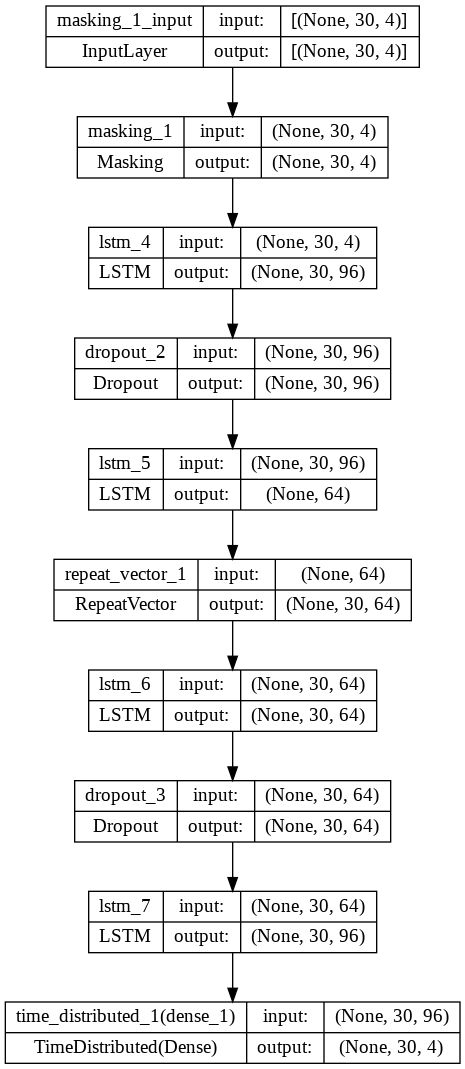

In [ ]:
model = tuner.hypermodel.build(best_hps)
plot_model(model, show_shapes=True, show_layer_names=True)

Compiling and training the model on these parameters

In [ ]:
hypermodel_epochs = 100
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=best_hps.get('learning_rate')))
with tf.device(computing_resource):
    history = model.fit(windowed_train,
                        windowed_train, 
                        epochs=hypermodel_epochs, 
                        validation_data=(windowed_val, windowed_val))

Epoch 1/100
371/371 [==============================] - 35s 58ms/step - loss: 0.4210 - val_loss: 0.3253
Epoch 2/100
371/371 [==============================] - 10s 26ms/step - loss: 0.3210 - val_loss: 0.3032
Epoch 3/100
371/371 [==============================] - 10s 27ms/step - loss: 0.3074 - val_loss: 0.2934
Epoch 4/100
371/371 [==============================] - 10s 27ms/step - loss: 0.2994 - val_loss: 0.2877
Epoch 5/100
371/371 [==============================] - 10s 27ms/step - loss: 0.2934 - val_loss: 0.2816
Epoch 6/100
371/371 [==============================] - 10s 26ms/step - loss: 0.2882 - val_loss: 0.2799
Epoch 7/100
371/371 [==============================] - 10s 27ms/step - loss: 0.2840 - val_loss: 0.2748
Epoch 8/100
371/371 [==============================] - 11s 30ms/step - loss: 0.2803 - val_loss: 0.2723
Epoch 9/100
371/371 [==============================] - 11s 31ms/step - loss: 0.2768 - val_loss: 0.2704
Epoch 10/100
371/371 [==============================] - 9s 25ms/step - lo

Taking the epoch where metrics have been best and re-training the model only for that number of epochs

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Epoch with lowest validation loss: {best_epoch}')

hypermodel_best_epoch = tuner.hypermodel.build(best_hps)
with tf.device(computing_resource):
    history = hypermodel_best_epoch.fit(windowed_train, 
                                        windowed_train, 
                                        epochs=best_epoch, 
                                        validation_data=(windowed_val, windowed_val))

Epoch with lowest validation loss: 97
Epoch 1/97
371/371 [==============================] - 26s 40ms/step - loss: 0.4318 - val_loss: 0.3289
Epoch 2/97
371/371 [==============================] - 10s 26ms/step - loss: 0.3225 - val_loss: 0.3059
Epoch 3/97
371/371 [==============================] - 10s 26ms/step - loss: 0.3083 - val_loss: 0.2943
Epoch 4/97
371/371 [==============================] - 10s 26ms/step - loss: 0.3004 - val_loss: 0.2880
Epoch 5/97
371/371 [==============================] - 10s 26ms/step - loss: 0.2942 - val_loss: 0.2827
Epoch 6/97
371/371 [==============================] - 10s 26ms/step - loss: 0.2898 - val_loss: 0.2772
Epoch 7/97
371/371 [==============================] - 10s 26ms/step - loss: 0.2855 - val_loss: 0.2739
Epoch 8/97
371/371 [==============================] - 10s 26ms/step - loss: 0.2824 - val_loss: 0.2720
Epoch 9/97
371/371 [==============================] - 10s 26ms/step - loss: 0.2793 - val_loss: 0.2706
Epoch 10/97
371/371 [=======================

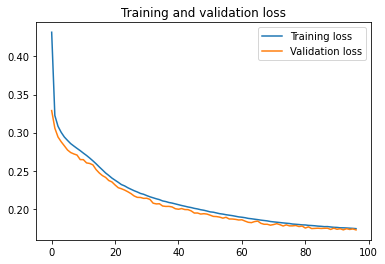

In [ ]:
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluation

### Metrics

The plot shows a gradual decrease in both training and validation loss, with validation steadily staying below training. No sign of overfitting. This means that the model gets better and better at reconstructing the original input.

### Predictions

Create input reconstructions

In [ ]:
predictions = model.predict(windowed_test)

3764/3764 [==============================] - 27s 6ms/step


Check predictions shape

In [ ]:
predictions.shape

(120447, 30, 4)

### MAE calculation

Calculate MAE for each window

In [ ]:
maes = []
for i in range(0, len(predictions)):
    maes.append(np.mean(np.abs(predictions[i] - windowed_test[i]), axis=1))

Isolating MAE for each row

In [ ]:
mae_by_row_dup = []
for i in maes:
    for element in i:
        mae_by_row_dup.append(element)

Checking out total number of MAEs

In [ ]:
print(len(mae_by_row_dup))

3613410


### MAE averaging

For each "real" row index, this returns a list of duplicate row indices (one row can appear multiple times in several windows)

In [ ]:
# Per ogni indice di riga "vera" (da 0 a 722787), questa funzione restituisce 
# una lista di indici di duplicati. Ad esempio:
# 30: [30, 36, 42, 48, 54]
# 0 : [0]
duplicate_dict_patients = []   
total_rows = 0

# Per ogni paziente:
for k in range(len(window_count_by_patient)):
  
    # Prendo l'indice della prima vera riga riferita a quel paziente k
    # Ad es., la prima riga del primo paziente sarà 0, 
    # la prima riga del secondo paziente sarà magari 100, ecc.
    start_index = start_indices_by_patient[k]

    # Creo un dizionario, come quello definito sopra
    dic = {t: [] for t in range(len(test))}

    # Per ogni finestra riferita al paziente k:
    # (necessario perché non tutti i pazienti hanno lo stesso numero di finestre)
    for i in range(window_count_by_patient[k]):

        # Assumo inizialmente che la dimensione effettiva della finestra sia 30
        ub = window_size

        # Nel caso in cui sia l'ultima finestra del paziente, la dimensione effettiva è < 30.
        # Infatti, sebbene la struttura dati sia di lunghezza 30, 
        # magari 3 sono righe padding di zeri. Quindi la dimensione effettiva è 27.
        # Dimensione effettiva = Window size - numero righe padding
        # Non vogliamo considerare le righe di padding nel calcolo della MAE.
        if (i == window_count_by_patient[k] - 1):
            ub = window_size - remainders_by_patient[k]

        # Per ogni elemento della finestra:
        for j in range(ub):
            # La vera riga 0 corrisponderà alla finta riga 1;
            # La vera riga 1 corrisponderà alla finta riga 2;
            # ...
            # La vera riga 29 corrisponderà alla finta riga 30;
            dic[start_index+j].append(total_rows)
            total_rows += 1
        
        # Aumento start_index di window_shift, ma total_rows rimane uguale
        start_index += window_shift
        # La vera riga 6 corrisponderà alla finta riga 30;
        # La vera riga 7 corrisponderà alla finta riga 31;
        # ...
        # La vera riga 36 corrisponderà alla finta riga 60;

    # Terminata l'ultima finestra, aumento total_rows di un eventuale numero di righe padding.
    # Questo serve per evitare di ripartire dal paziente successivo,
    # considerando anche le righe padding.
    total_rows += remainders_by_patient[k]

    # Il dizionario viene messo in un array.
    duplicate_dict_patients.append(dic)

Given the list above, average MAEs for duplicate rows 

In [ ]:
mae_by_row = []
maes_by_patient = {}
patient_id = 0
for patient_dict in duplicate_dict_patients:
    maes_by_patient[test_patients[patient_id]] = []
    for key, value in patient_dict.items():
        if len(value) != 0:
            mean = []
            for index in value:
                mean.append(mae_by_row_dup[index])
            mae_by_row.append(np.mean(np.array(mean)))
            maes_by_patient[test_patients[patient_id]].append(np.mean(np.array(mean))) 
    patient_id += 1   

As visible, there are no more duplicates

In [ ]:
len(mae_by_row)

722787

### Anomaly detection

Below there are patient-by-patient plots of anomalies found. We fix a 95% error tolerance calculated on the max error value for each patient.


Paziente 1004:
Errore massimo: 1.4283496141433716
Soglia massima: 1.2855146527290344



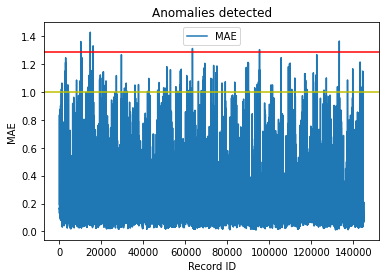


Paziente 1006:
Errore massimo: 1.3886370658874512
Soglia massima: 1.249773359298706



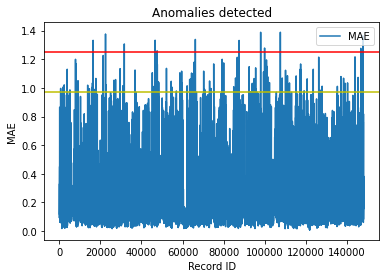


Paziente 3001:
Errore massimo: 1.415687918663025
Soglia massima: 1.2741191267967225



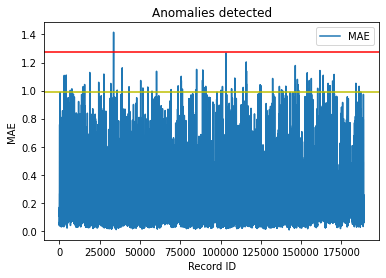


Paziente 3006:
Errore massimo: 1.5387420654296875
Soglia massima: 1.3848678588867187



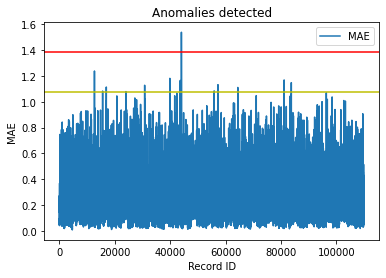


Paziente 4002:
Errore massimo: 1.40720534324646
Soglia massima: 1.266484808921814



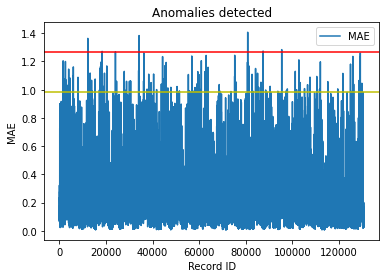

In [ ]:
reconstruction_thresholds_max = []
reconstruction_thresholds_min = []

for p in range(0, len(maes_by_patient)):

    patient_id = test_patients[p]
    max_error = max(maes_by_patient[patient_id])
    threshold_max = ((max_error) / 10 * 9)
    threshold_min= ((max_error) / 10 * 7)
    reconstruction_thresholds_max.append(threshold_max)
    reconstruction_thresholds_min.append(threshold_min)
    print(f'\nPaziente {patient_id}:\nErrore massimo: {max_error}\nSoglia massima: {threshold_max}\n')
    plt.plot(range(len(maes_by_patient[patient_id])), 
             maes_by_patient[patient_id],  
             label='MAE')
    plt.axhline(threshold_max, color='r')
    plt.axhline(threshold_min, color='y')
    plt.title('Anomalies detected') 
    plt.xlabel('Record ID')
    plt.ylabel('MAE') 
    plt.legend()
    plt.show()

In [ ]:
row_index = 0
f = open("detected_anomalies.csv", "w")
f.write("patient, tsDate,off,probable_off\n")

for patient in maes_by_patient.keys():
  for mae in range(len(maes_by_patient[patient])):
        if maes_by_patient[patient][mae] > reconstruction_thresholds_max[row_index]:
          row = str(test_by_patient[row_index].iloc[mae]['patient']) + ","
          row += str(test_by_patient[row_index].iloc[mae]['tsDate']) + ","
          row += "True,"
          row += "False"
          row += "\n"
          f.write(row)
        elif maes_by_patient[patient][mae] > reconstruction_thresholds_min[row_index]:
          row = str(test_by_patient[row_index].iloc[mae]['patient']) + ","
          row += str(test_by_patient[row_index].iloc[mae]['tsDate']) + ","
          row += "False,"
          row += "True"
          row += "\n"
          f.write(row)
  row_index += 1
f.close()

In [ ]:
detected_anomalies = pd.read_csv('detected_anomalies.csv')
detected_anomalies.head(100)

,patient,tsDate,off,probable_off
0,1004,2019-08-31 09:05:20.547,False,True
1,1004,2019-08-31 09:40:25.902,False,True
2,1004,2019-08-31 09:54:47.128,False,True
3,1004,2019-08-31 09:54:57.141,False,True
4,1004,2019-08-31 09:55:07.154,False,True
...,...,...,...,...
95,1004,2019-09-13 08:26:14.957,False,True
96,1004,2019-09-13 12:23:01.017,False,True
97,1004,2019-09-13 17:01:21.000,False,True
98,1004,2019-09-13 17:15:31.893,False,True


Number of detected anomalies

In [ ]:
print(len(detected_anomalies[detected_anomalies.probable_off==True]))

543


In [ ]:
print(len(detected_anomalies[detected_anomalies.off==True]))

33
